In [ ]:
!pip install diffusers
!pip install git+https://github.com/openai/CLIP.git
!pip install scikit-learn

In [ ]:
import os
import torch
import numpy as np
import random
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from diffusers import DiffusionPipeline, UNet2DModel, DDPMScheduler
import clip
from transformers import TrainingArguments, DefaultDataCollator
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.optim as optim


In [ ]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = os.path.abspath(root_dir)
        print(f"Dataset root directory: {self.root_dir}")
        self.transform = transform
        self.image_paths = []
        for subdir, _, files in os.walk(self.root_dir):
            for file in files:
                if file.lower().endswith('.jpg'):
                    image_path = os.path.join(subdir, file)
                    self.image_paths.append(image_path)
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {self.root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = CelebADataset('/kaggle/input/celeba-hq-facial-identity-dataset/train', transform=transform)
test_dataset = CelebADataset('/kaggle/input/celeba-hq-facial-identity-dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [ ]:
# # train model

# model_id = "google/ddpm-cifar10-32"
# unet = UNet2DModel.from_pretrained(model_id)
# scheduler = DDPMScheduler.from_pretrained(model_id)

# # DDIM
# scheduler.set_timesteps(num_inference_steps=50)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# unet.to(device)

# training_args = TrainingArguments(
#     output_dir="./results",
#     per_device_train_batch_size=64,
#     num_train_epochs=5,  
#     logging_dir="./logs",
#     logging_steps=100,  
#     save_steps=5_000,  
#     evaluation_strategy="steps",  
#     eval_steps=5_000,
#     learning_rate=1e-4,  
#     report_to="tensorboard",
# )

In [ ]:
model_id = "shalpin87/diffusion_celeba"
pipeline = DiffusionPipeline.from_pretrained(model_id)

def generate_synthetic_dataset(num_images=10):
    synth_images = []
    resize_transform = transforms.Resize((128, 128))
    with torch.no_grad():
        print(f"Generating {num_images} images")
        for i in range(num_images):
            result = pipeline(num_inference_steps=50)
            image = result.images[0]
            image = resize_transform(image)
            image = transforms.ToTensor()(image).unsqueeze(0)
            synth_images.append(image)
            print(f"Generated image {i+1}/{num_images}")
    return torch.cat(synth_images)

if __name__ == "__main__":
    synth_images = generate_synthetic_dataset(num_images=10)
    torch.save(synth_images, "synthetic_dataset.pth")
    
    # check
    for i in range(min(len(synth_images), 10)):
        image = transforms.ToPILImage()(synth_images[i].cpu().squeeze(0))
        image.save(f"generated_image_{i+1}.png")


random labels or cluster information extracted by a pre-trained feature extractor (e.g., the CLIP image encoder) can be used as the implicit labels. 

In [ ]:
# CLIP ： extract_features -> generate pseudo label

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def load_dataset(file_path):
    data = torch.load(file_path)
    return data

# 提取图像特征
def extract_features(data_loader):
    all_features = []
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            features = model.encode_image(images)
            all_features.append(features.cpu())
    return torch.cat(all_features)

class SyntheticDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(image)
            image = self.transform(image)
        return image

# for CLIP
resize_transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# for save
resize_transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

synthetic_images = load_dataset('synthetic_dataset.pth')

synthetic_dataset = SyntheticDataset(synthetic_images, transform=resize_transform_224)
synthetic_data_loader = DataLoader(synthetic_dataset, batch_size=32, shuffle=False)

# 提取图像特征
all_features = extract_features(synthetic_data_loader)

# 聚类
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, n_init=10)
labels = kmeans.fit_predict(all_features)

class PseudoLabeledDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(image)
            image = self.transform(image)
        return image, self.labels[idx]

pseudo_labeled_dataset = PseudoLabeledDataset(synthetic_images, labels, transform=resize_transform_128)
pseudo_labeled_data_loader = DataLoader(pseudo_labeled_dataset, batch_size=32, shuffle=True)

# save
def save_dataset(dataset, file_path):
    images = []
    labels = []
    for img, label in dataset:
        img = transforms.Resize((128, 128))(img)
        images.append(img)
        labels.append(label)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    torch.save({'images': images, 'labels': labels}, file_path)

save_dataset(pseudo_labeled_dataset, 'pseudo_labeled_dataset.pth')

In [ ]:
### check
# 加载伪标签数据集
def load_pseudo_labeled_dataset(file_path):
    data = torch.load(file_path)
    images = data['images']
    labels = data['labels']
    return images, labels

# 加载伪标签数据集
pseudo_labeled_data = load_pseudo_labeled_dataset('pseudo_labeled_dataset.pth')
pseudo_labeled_images = pseudo_labeled_data[0]
pseudo_labeled_labels = pseudo_labeled_data[1]

# 打印一些样本的形状和标签
print(f"Number of samples: {len(pseudo_labeled_images)}")
print(f"Sample image shape: {pseudo_labeled_images[0].shape}")
print(f"Sample label: {pseudo_labeled_labels[0].item()}")

# 查看前10个样本
for i in range(min(10, len(pseudo_labeled_images))):
    img = transforms.ToPILImage()(pseudo_labeled_images[i].cpu())
    img.show()
    print(f"Label for image {i+1}: {pseudo_labeled_labels[i].item()}")

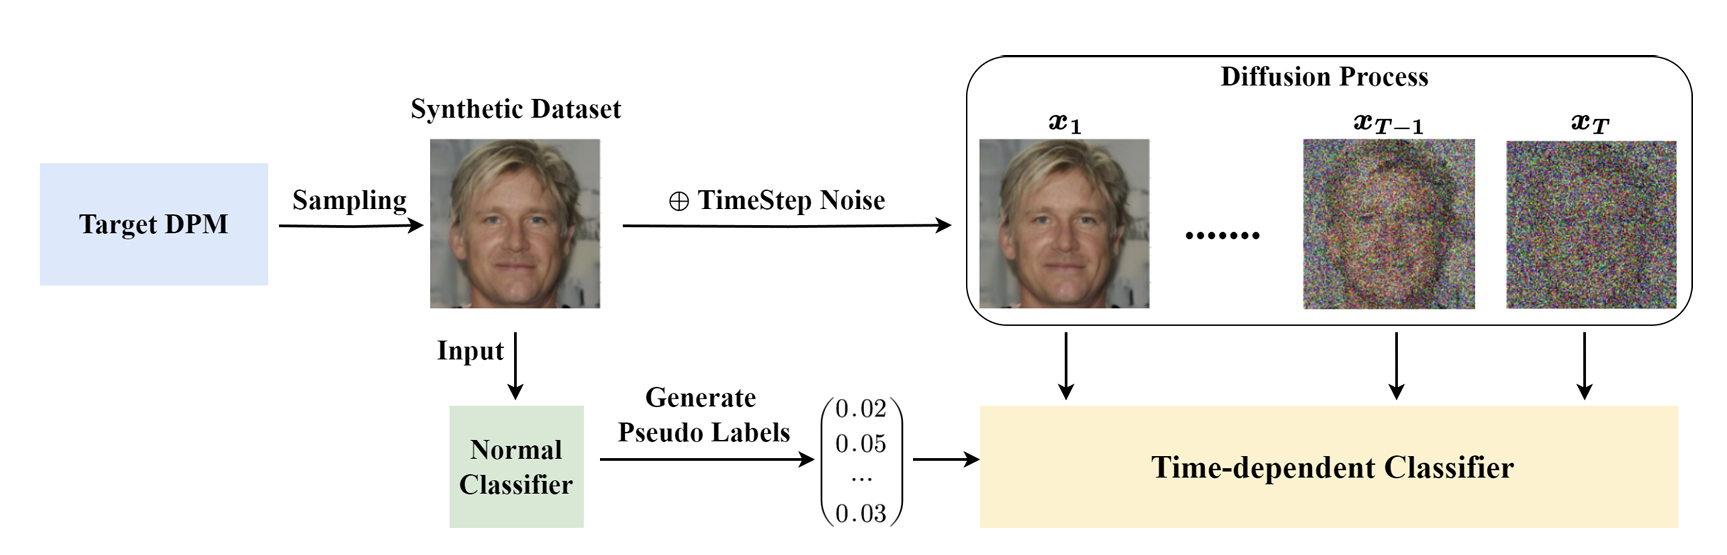

In [ ]:
# 时间依赖的噪声添加
def add_time_dependent_noise(images, t, noise_std=0.1):
    noise = torch.normal(mean=0.0, std=noise_std, size=images.size()).to(images.device)
    noisy_images = images + noise * t
    return noisy_images

class TimeDependentDataset(Dataset):
    def __init__(self, images, labels, time_steps, transform=None):
        self.images = images
        self.labels = labels
        self.time_steps = time_steps
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        t = self.time_steps[idx]
        noisy_image = add_time_dependent_noise(image.unsqueeze(0), t).squeeze(0)
        if self.transform:
            noisy_image = self.transform(noisy_image)
        return noisy_image, label

class TimeDependentClassifier(nn.Module):
    def __init__(self, num_classes=10, lambda_param=1.0):
        super(TimeDependentClassifier, self).__init__()
        self.model = models.resnet34(pretrained=False)  # ResNet34
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.time_layer = nn.Linear(1, self.model.fc.in_features)
        self.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.lambda_param = lambda_param

    def forward(self, x, t):
        time_embedding = self.time_layer(t)
        x = self.model(x)
        time_embedding = self.fc(time_embedding)
        
        # lambda 应用于时间嵌入 看不太懂
        x += self.lambda_param * time_embedding
        
        return x

# KL散度损失函数
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super(KLDivergenceLoss, self).__init__()

    def forward(self, p, q):
        kl_div = nn.KLDivLoss(reduction='batchmean')
        return kl_div(p.log_softmax(dim=-1), q.softmax(dim=-1))

# train
def train_model(model, data_loader, optimizer, criterion, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            t = torch.linspace(0, 1, images.size(0), device=device).unsqueeze(1)  # 时间变量

            outputs = model(images, t)
            
            target_distribution = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1.0)

            loss = criterion(outputs, target_distribution)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(data_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

data = torch.load('pseudo_labeled_dataset.pth')
images = data['images']
labels = data['labels']

num_images = len(images)
time_steps = torch.linspace(0, 1, num_images)

resize_transform = transforms.Compose([
    transforms.Resize((128, 128), antialias=True),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = TimeDependentDataset(images, labels, time_steps, transform=resize_transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

lambda_param = 0
model = TimeDependentClassifier(num_classes=10, lambda_param=lambda_param)
# We use the AdamW optimizer with a learning rate of 1e-4 to train the time-dependent classifier.
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = KLDivergenceLoss()

train_model(model, data_loader, optimizer, criterion)

torch.save(model.state_dict(), 'time_dependent_classifier.pth')

# for each integer value of λ within the range of [0, 50]
# num_models = 51

# for lambda_param in range(num_models):
#     print(f"Training model with lambda = {lambda_param}")
    
#     model = TimeDependentClassifier(num_classes=10, lambda_param=lambda_param)
#     optimizer = optim.Adam(model.parameters(), lr=1e-4)
#     criterion = KLDivergenceLoss()
    
#     train_model(model, data_loader, optimizer, criterion, num_epochs=10)

#     torch.save(model.state_dict(), f'time_dependent_classifier_lambda_{lambda_param}.pth')

In [ ]:
class TimeDependentClassifier(nn.Module):
    def __init__(self, num_classes=10, lambda_param=1.0):
        super(TimeDependentClassifier, self).__init__()
        self.model = models.resnet34(pretrained=False)  # ResNet34
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.time_layer = nn.Linear(1, self.model.fc.in_features)
        self.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.lambda_param = lambda_param

    def forward(self, x, t):
        time_embedding = self.time_layer(t)
        x = self.model(x)
        time_embedding = self.fc(time_embedding)
        
        x += self.lambda_param * time_embedding
        
        return x

classifier = TimeDependentClassifier(num_classes=10)
classifier.load_state_dict(torch.load('time_dependent_classifier.pth'))
classifier.eval()

# 模型？
model_id = "shalpin87/diffusion_celeba"  # 待1
pipeline = DiffusionPipeline.from_pretrained(model_id)

def generate_extracted_data(num_images=10):
    extracted_images = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classifier.to(device)

    with torch.no_grad():
        print(f"Generating {num_images} images")
        for i in range(num_images):
            result = pipeline(num_inference_steps=50) 
            image = result.images[0]
            image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
            
            # 计算分类器输出并进行时间依赖调整 看不懂
            t = torch.tensor([i / num_images], dtype=torch.float32, device=device).repeat(image_tensor.size(0), 1)
            logits = classifier(image_tensor, t)
            print(f"Image {i+1}/{num_images} logits: {logits}")
            
            extracted_images.append(image_tensor.cpu().squeeze(0))
            print(f"Generated image {i+1}/{num_images}")
    
    return torch.stack(extracted_images)

if __name__ == "__main__":
    extracted_data = generate_extracted_data(num_images=3)
    torch.save(extracted_data, "extracted_data.pth")
   

    ### check
    for i in range(min(len(extracted_data), 10)): 
        image = transforms.ToPILImage()(extracted_data[i].cpu())
        image.save(f"extracted_image_{i+1}.png")
        print(f"Extracted image {i+1} saved as extracted_image_{i+1}.png")


In [ ]:
# MSE的粗略寻找

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)  # 选择一个固定的种子

# 计算图像之间的均方误差 (MSE)
def compute_mse(img1, img2):
    img1 = img1.view(-1).cpu().numpy()
    img2 = img2.view(-1).cpu().numpy()
    return mean_squared_error(img1, img2)

def load_and_transform_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image)
    return image

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = os.path.abspath(root_dir)  
        print(f"Dataset root directory: {self.root_dir}")
        self.transform = transform
        self.image_paths = []
        for subdir, _, files in os.walk(self.root_dir):
            for file in files:
                if file.lower().endswith('.jpg'):
                    image_path = os.path.join(subdir, file)
                    self.image_paths.append(image_path)
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {self.root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image, "path": img_path}  # 图像路径


if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    train_dataset = CelebADataset('/kaggle/input/celeba-hq-facial-identity-dataset/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

    extracted_image = load_and_transform_image('extracted_image_3.png', transform).unsqueeze(0).to(device)
    
    # 使用 train_loader 遍历图像
    min_mse = float('inf')
    most_similar_image_index = -1
    batch_count = 0

    total_batches = len(train_loader)
    
    for batch_idx, batch in enumerate(train_loader):
        print(f"Processing batch {batch_idx + 1}/{total_batches}")

        img = batch['pixel_values'].to(device)

        for i in range(img.size(0)):
            image = img[i]
            if image.dim() == 3:
                # 计算 MSE
                mse = compute_mse(extracted_image.squeeze(0), image)
                if mse < min_mse:
                    min_mse = mse
                    most_similar_image_index = batch_count * train_loader.batch_size + i

        batch_count += 1

    # 对应的图像
    most_similar_image_path = train_dataset.image_paths[most_similar_image_index]
    print(f"Most similar image index: {most_similar_image_index}")
    print(f"Most similar image path: {most_similar_image_path}")
